In [114]:
#Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import shap


## 1. Load data & handle missing values

In [52]:
# Load dataset
df = pd.read_csv("C:/Users/Anh Thu/Downloads/Master/Customer Data/Assignment_data.csv")

In [53]:
# Check missing values
missing_values_count = df.isnull().sum()
print("Before dropping missing value:", missing_values_count)

# Drop missing value in Devide column
df['device'] = df['device'].replace(["", " "], np.nan)
df = df.dropna(subset=['device'])

print("After dropping missing value:", df.isnull().sum())

Before dropping missing value: device    9
score     0
time      0
dtype: int64
After dropping missing value: device    0
score     0
time      0
dtype: int64


## 2. Exploratory Data Analysis

In [54]:
# Count unique device values -> players
unique_device_count = df['device'].nunique()
print("Number of unique device values:", unique_device_count)

Number of unique device values: 25956


In [55]:
# Convert Unix time to datetime format
df['converted_time'] = pd.to_datetime(df['time'], unit='s', origin='unix')

# Split datetime into separate date and time columns
df['date'] = df['converted_time'].dt.date  # extract date
df['time_hr'] = df['converted_time'].dt.strftime('%H:%M:%S')  # extract time in HH:MM:SS format

In [56]:
# Get the earliest and latest dates
earliest_date = df['converted_time'].min().date()
latest_date = df['converted_time'].max().date()
print("Earliest date:", earliest_date)
print("Latest date:", latest_date)

Earliest date: 2015-01-13
Latest date: 2016-05-24


C:\Users\Anh Thu\AppData\Local\Temp\ipykernel_14044\264207926.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_avg_score = df.groupby('month_cat')['score'].mean() # we can calculate mean score or total score


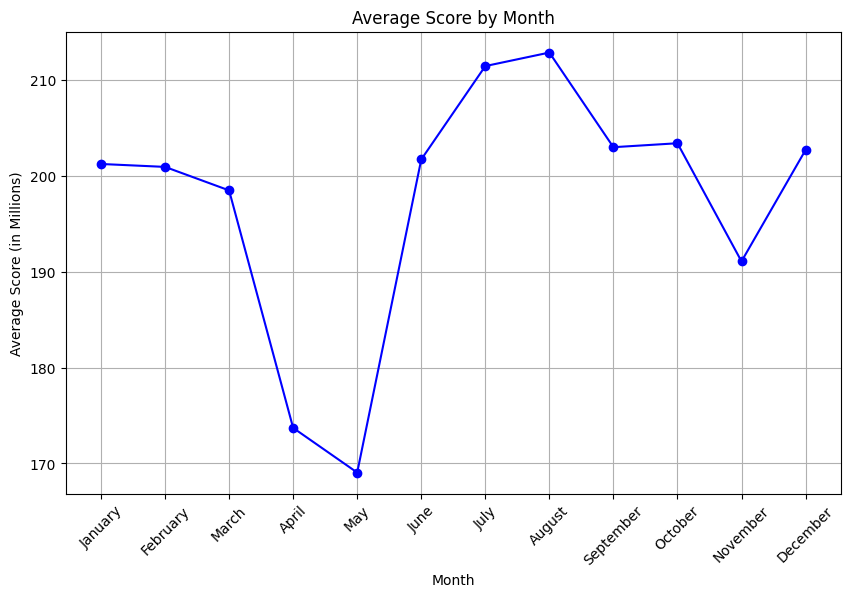

In [60]:
#Extract month
df['month'] = pd.to_datetime(df['date']).dt.month_name()
categories = ['January', 'February', 'March', 'April', 'May', 'June',
             'July', 'August', 'September', 'October', 'November', 'December']
df['month_cat'] = pd.Categorical(df['month'], categories=categories)
# Average score 
monthly_avg_score = df.groupby('month_cat')['score'].mean() # we can calculate mean score or total score
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_score.index, monthly_avg_score.values, marker='o', color='b', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average Score (in Millions)')
plt.title('Average Score by Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


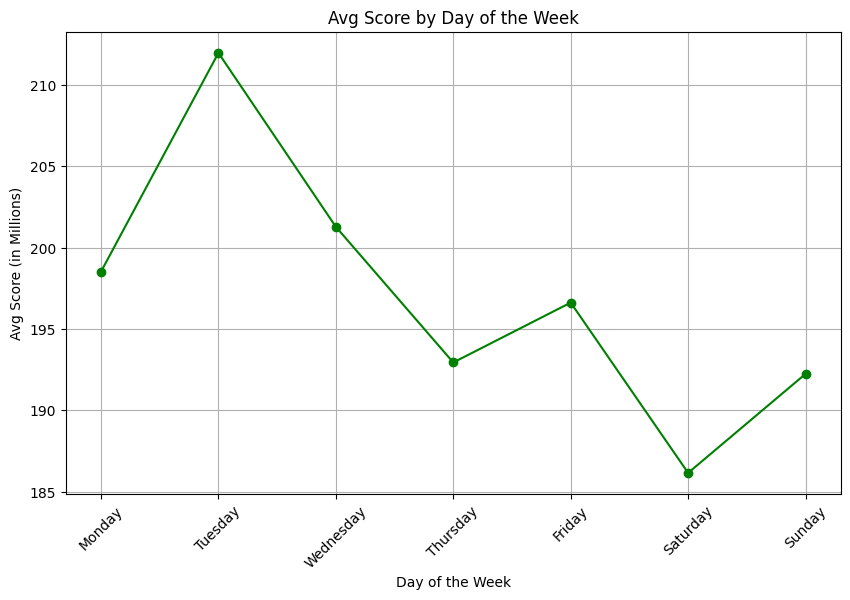

In [61]:
# Extract day of the week from 'date' column
df['day_of_week'] = pd.to_datetime(df['date']).dt.day_name()

# Define order for days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days_order, ordered=True)

# Mean score by day of the week
daily_avg_score = df.groupby('day_of_week', observed=True)['score'].mean()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(daily_avg_score.index, daily_avg_score.values, marker='o', color='g', linestyle='-')
plt.xlabel('Day of the Week')
plt.ylabel('Avg Score (in Millions)')
plt.title('Avg Score by Day of the Week')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

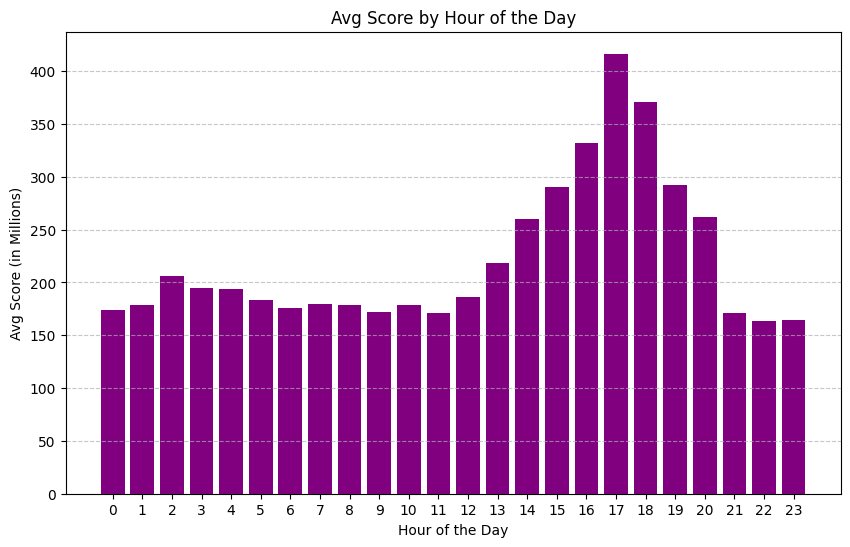

In [62]:
# Extract hour from 'time_hr'
df['hour_of_day'] = pd.to_datetime(df['time_hr'], format='%H:%M:%S').dt.hour

# Calculate mean score by hour of the day
hourly_avg_score = df.groupby('hour_of_day')['score'].mean()

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(hourly_avg_score.index, hourly_avg_score.values, color='purple')
plt.xlabel('Hour of the Day')
plt.ylabel('Avg Score (in Millions)')
plt.title('Avg Score by Hour of the Day')
plt.xticks(range(0, 24))  # ensures every hour is shown on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Note: here you can experiment with plotting score by hour of the day for a different timezone

Summary statistics of the 'score' variable:


count    153920.000000
mean        195.927034
std         443.620259
min           0.000000
25%          20.000000
50%          72.000000
75%         205.000000
max       20964.000000
Name: score, dtype: float64

Median of 'score': 72.0


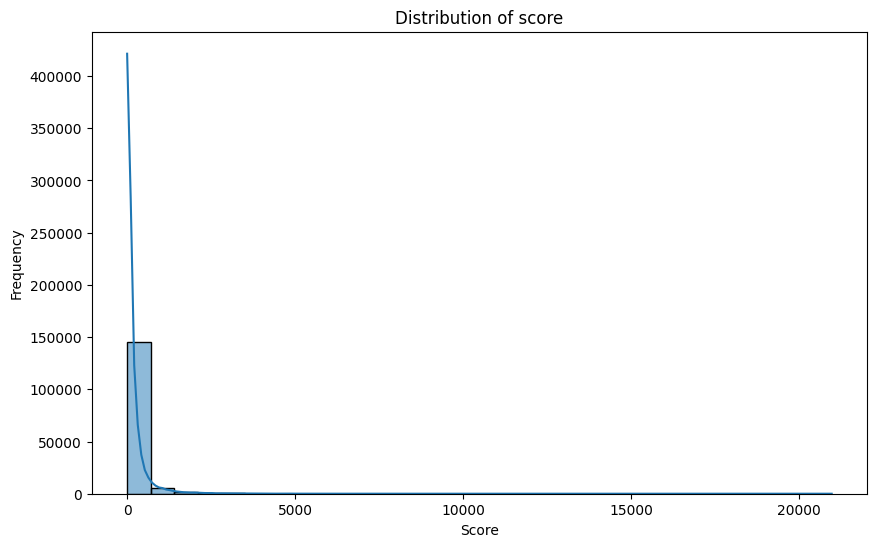

In [65]:
# Describe 'score'
print("Summary statistics of the 'score' variable:")
display(df['score'].describe())
# Median value of 'score'
print("Median of 'score':", df['score'].median())
# What does it mean that the mean and the median are far away? -> data is skewed
# Plot the distribution of 'score' variable
plt.figure(figsize=(10, 6))
sns.histplot(df['score'], kde=True, bins=30)
plt.title('Distribution of score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [66]:
# Score variability for each player
# Calculate score standard deviation per player
score_variability = df.groupby('device')['score'].std().reset_index()

# Rename columns
score_variability.columns = ['player_id', 'score_std_dev']

# Check if it's correct
print(score_variability.head())

         player_id  score_std_dev
0                0      98.969271
1  000000000000000     398.282132
2  010941525590041            NaN
3  012345678901237       0.707107
4  012345678912345     842.582951



Summary statistics of score variability:
count    14534.000000
mean       167.230254
std        354.086570
min          0.000000
25%         26.870058
50%         64.298478
75%        154.261945
max       9060.710513
Name: score_std_dev, dtype: float64


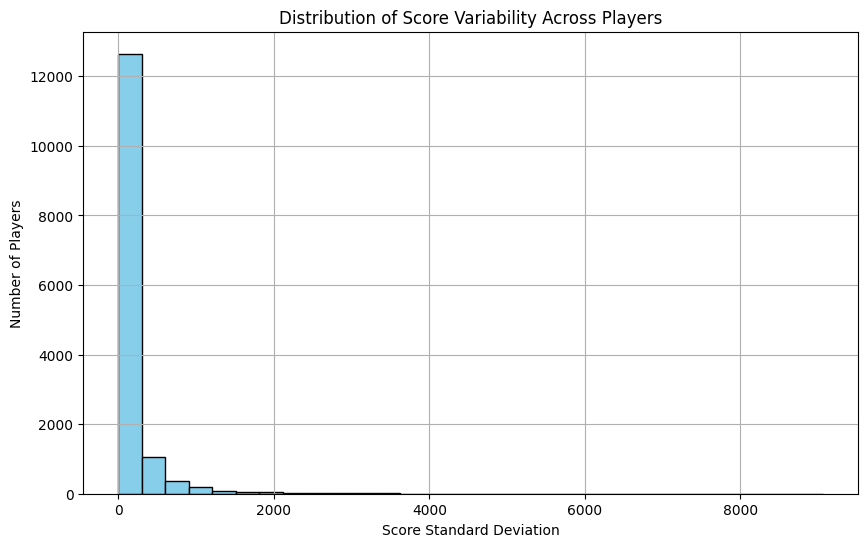

In [67]:
# Summary statistics of player score variability
print("\nSummary statistics of score variability:")
print(score_variability['score_std_dev'].describe())
# Plot distribution of score variability
plt.figure(figsize=(10, 6))
plt.hist(score_variability['score_std_dev'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Score Standard Deviation')
plt.ylabel('Number of Players')
plt.title('Distribution of Score Variability Across Players')
plt.grid(True)
plt.show()

In [68]:
# Identify players with very high or very low score variability
high_variability = score_variability[score_variability['score_std_dev'] > score_variability['score_std_dev'].quantile(0.75)]
low_variability = score_variability[score_variability['score_std_dev'] < score_variability['score_std_dev'].quantile(0.25)]

print("\nPlayers with high score variability (top 25%):")
print(high_variability)

print("\nPlayers with low score variability (bottom 25%):")
print(low_variability)


Players with high score variability (top 25%):
             player_id  score_std_dev
1      000000000000000     398.282132
4      012345678912345     842.582951
13     013703000737787     413.682418
18     014097008062978     253.374888
47     351508060116685     161.927453
...                ...            ...
25708   A000002F82D51D     178.617188
25727   A000002F857DD0     277.499910
25753   A00000312BCF53     164.688135
25822   A1000019612ACD     241.726636
25884   a00000088b0c80     253.263697

[3634 rows x 2 columns]

Players with low score variability (bottom 25%):
             player_id  score_std_dev
3      012345678901237       0.707107
6      012403004537025       9.464847
10     013460002038033      10.606602
11     013689004460635       7.229651
14     014035001426733      13.892444
...                ...            ...
25935   a0000008bd1188       9.643651
25936   a0000008bd18c7      16.238455
25940   a0000008bea733      12.727922
25944   a0000037802dc2       7.681146
259

In [37]:
# Check number of players with a single score
single_score_players = df.groupby('device')['score'].count()
single_score_players = single_score_players[single_score_players == 1]
print("Number of players with only one score:", len(single_score_players))

Number of players with only one score: 11422


In [69]:
# Count the number of sessions per unique device (player)
session_counts = df.groupby('device').size().reset_index(name='session_count')
# Label players based on their session count as one-session or multi-session
session_counts['session_label'] = session_counts['session_count'].apply(lambda x: 'one-session' if x == 1 else 'multi-session')
# Assign 1 to players who played at least 10 times
session_counts['played_10_plus'] = (session_counts['session_count'] >= 10).astype(int)
# Inspect to check that it's correct
print(session_counts.head())
print(session_counts.columns)
# Show counts of each label to verify
#how many players played one-session vs multiple and players who played less than 10 times vs > 10 times
print(session_counts['session_label'].value_counts())
print(session_counts['played_10_plus'].value_counts())

            device  session_count  session_label  played_10_plus
0                0              4  multi-session               0
1  000000000000000             40  multi-session               1
2  010941525590041              1    one-session               0
3  012345678901237              2  multi-session               0
4  012345678912345           1618  multi-session               1
Index(['device', 'session_count', 'session_label', 'played_10_plus'], dtype='object')
session_label
multi-session    14534
one-session      11422
Name: count, dtype: int64
played_10_plus
0    23093
1     2863
Name: count, dtype: int64


In [70]:
# Merge session_counts back to the original dataframe
df = df.merge(session_counts[['device', 'session_count', 'session_label', 'played_10_plus']], on='device', how='left')

In [71]:
df.head()

,device,score,time,converted_time,date,time_hr,month,month_cat,day_of_week,hour_of_day,session_count,session_label,played_10_plus
0,352610060979119,7,1421157320,2015-01-13 13:55:20,2015-01-13,13:55:20,January,January,Tuesday,13,4,multi-session,0
1,352610060979119,0,1421157288,2015-01-13 13:54:48,2015-01-13,13:54:48,January,January,Tuesday,13,4,multi-session,0
2,352610060979119,6,1421157344,2015-01-13 13:55:44,2015-01-13,13:55:44,January,January,Tuesday,13,4,multi-session,0
3,99000072289368,106,1421163166,2015-01-13 15:32:46,2015-01-13,15:32:46,January,January,Tuesday,15,2,multi-session,0
4,357470044931974,278,1421163783,2015-01-13 15:43:03,2015-01-13,15:43:03,January,January,Tuesday,15,910,multi-session,1


## 3. Create churn and no-churn label

In [40]:
# Find each player's t0 (first play)
t0 = df.groupby('device')['converted_time'].min().rename('t0')
df = df.merge(t0, on='device', how='left')
df = df.sort_values(['device', 'converted_time']).reset_index(drop=True) #sort sessions per player



In [ ]:
# compute time to next play per session (in days) for exploratory analysis
df['next_time'] = df.groupby('device')['converted_time'].shift(-1)
df['time_to_next_days'] = (df['next_time'] - df['converted_time']).dt.total_seconds() / (3600 * 24)


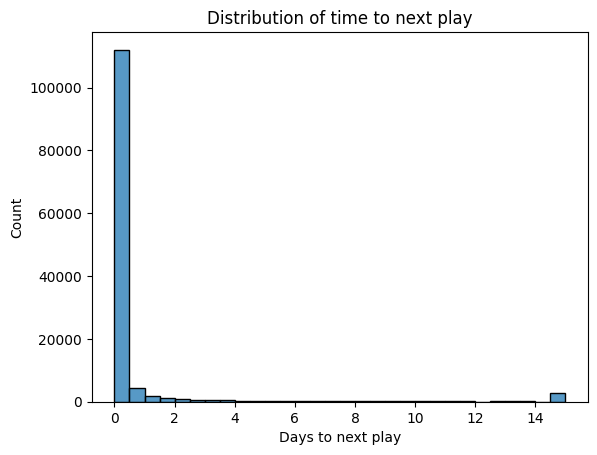

In [87]:
# Summary of time-to-next distribution
time_to_next = df['time_to_next_days'].dropna()
sns.histplot(time_to_next.clip(upper=15), bins=30) 
plt.xlabel('Days to next play')
plt.title('Distribution of time to next play')
plt.show()

In [88]:
# Choose OP and CP
OP_days = 2
CP_days = 15

# create windows (OP and CP)
windows = t0.reset_index().copy()
windows['OP_start'] = windows['t0']
windows['OP_end'] = windows['t0'] + pd.Timedelta(days=OP_days)
windows['CP_end'] = windows['OP_end'] + pd.Timedelta(days=CP_days)
tmp = df.merge(windows[['device','OP_start','OP_end','CP_end']], on='device', how='left')
tmp['in_OP'] = (tmp['converted_time'] >= tmp['OP_start']) & (tmp['converted_time'] < tmp['OP_end'])
tmp['in_CP'] = (tmp['converted_time'] >= tmp['OP_end']) & (tmp['converted_time'] < tmp['CP_end'])

# churn label per device
counts = tmp.groupby('device').agg(op_sessions=('in_OP','sum'), cp_sessions=('in_CP','sum')).reset_index()
counts['churn'] = np.where((counts['op_sessions']>=1) & (counts['cp_sessions']==0), 1,
                  np.where((counts['op_sessions']>=1) & (counts['cp_sessions']>0), 0, np.nan))


In [89]:

# Check churn distribution
print("Churn distribution:")
print(counts['churn'].value_counts(dropna=False))

print("\nProportion:")
print(counts['churn'].value_counts(normalize=True, dropna=False))

Churn distribution:
churn
1.0    22611
0.0     3345
Name: count, dtype: int64

Proportion:
churn
1.0    0.871128
0.0    0.128872
Name: proportion, dtype: float64


In [90]:
df.head()

,device,score,time,converted_time,date,time_hr,month,month_cat,day_of_week,hour_of_day,session_count,session_label,played_10_plus,next_time,time_to_next_days
0,352610060979119,7,1421157320,2015-01-13 13:55:20,2015-01-13,13:55:20,January,January,Tuesday,13,4,multi-session,0,2015-01-13 13:54:48,-0.000370
1,352610060979119,0,1421157288,2015-01-13 13:54:48,2015-01-13,13:54:48,January,January,Tuesday,13,4,multi-session,0,2015-01-13 13:55:44,0.000648
2,352610060979119,6,1421157344,2015-01-13 13:55:44,2015-01-13,13:55:44,January,January,Tuesday,13,4,multi-session,0,2015-01-14 00:38:05,0.446076
3,99000072289368,106,1421163166,2015-01-13 15:32:46,2015-01-13,15:32:46,January,January,Tuesday,15,2,multi-session,0,2015-01-14 04:40:05,0.546748
4,357470044931974,278,1421163783,2015-01-13 15:43:03,2015-01-13,15:43:03,January,January,Tuesday,15,910,multi-session,1,2015-01-13 15:50:05,0.004884


## 4. Feature Engineering

In [93]:
# Engineer features based on OP only
df_OP = tmp[tmp['in_OP'] == True]

op_features = df_OP.groupby('device').agg(
    total_games_OP=('score', 'count'),
    total_score_OP=('score', 'sum'),
    avg_score_OP=('score', 'mean'),
    max_score_OP=('score', 'max'),
    median_score_OP=('score','median'),
    std_score_OP=('score', 'std'),
    first_play_OP=('converted_time', 'min'),
    last_play_OP=('converted_time', 'max')
).reset_index()

# activity_days_OP
activity_days = df_OP.groupby('device')['converted_time'].apply(lambda x: x.dt.date.nunique()).rename('activity_days_OP').reset_index()
op_features = op_features.merge(activity_days, on='device', how='left')

# games_per_day_OP
op_features['games_per_day_OP'] = op_features['total_games_OP'] / op_features['activity_days_OP']

# recency_days_OP
op_features['recency_days_OP'] = (df_OP['OP_end'].max() - op_features['last_play_OP']).dt.days

# mean_session_interval_hours_OP
def mean_session_interval_hours(x):
    x_sorted = x.sort_values()
    if len(x_sorted) <= 1:
        return 0
    diffs = x_sorted.diff().dropna().dt.total_seconds() / 3600
    return diffs.mean()

intervals = df_OP.groupby('device')['converted_time'].apply(mean_session_interval_hours).rename('mean_session_interval_hours_OP').reset_index()
op_features = op_features.merge(intervals, on='device', how='left')

# score_trend_OP
def score_trend(x):
    if len(x) < 2:
        return 0  # or np.nan
    y = x['score'].values
    t = (x['converted_time'] - x['converted_time'].min()).dt.total_seconds()
    if np.all(y == y[0]) or np.all(t == 0):
        return 0
    try:
        slope = np.polyfit(t, y, 1)[0]
    except np.linalg.LinAlgError:
        slope = 0
    return slope

trend = df_OP.groupby('device').apply(score_trend).rename('score_trend_OP').reset_index()
op_features = op_features.merge(trend, on='device', how='left')

# max_games_per_day_OP
max_games_day = df_OP.groupby(['device', df_OP['converted_time'].dt.date]).size().groupby('device').max().rename('max_games_per_day_OP').reset_index()
op_features = op_features.merge(max_games_day, on='device', how='left')

# Fill NaN
op_features = op_features.fillna(0)

# Drop datetime columns if not used in modeling
op_features = op_features.drop(columns=['first_play_OP', 'last_play_OP'])

# Preview
op_features.head()


C:\Users\Anh Thu\AppData\Local\Temp\ipykernel_14044\1813238670.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend = df_OP.groupby('device').apply(score_trend).rename('score_trend_OP').reset_index()


,device,total_games_OP,total_score_OP,avg_score_OP,max_score_OP,median_score_OP,std_score_OP,activity_days_OP,games_per_day_OP,recency_days_OP,mean_session_interval_hours_OP,score_trend_OP,max_games_per_day_OP
0,0,3,174,58.000000,115,45.0,51.739733,1,3.0,411,0.015833,-0.289355,3
1,000000000000000,3,10,3.333333,7,2.0,3.214550,1,3.0,489,0.008889,0.040865,3
2,010941525590041,1,21,21.000000,21,21.0,0.000000,1,1.0,324,0.000000,0.000000,1
3,012345678901237,2,65,32.500000,33,32.5,0.707107,1,2.0,458,0.014444,-0.019231,2
4,012345678912345,5,56,11.200000,30,3.0,13.479614,1,5.0,459,0.003264,0.536571,5


In [96]:
# Merge churn counts with OP features
final_features = counts.merge(op_features, on='device', how='left')

# Drop leakage columns (sessions in OP/CP) and fill NaNs for single-session players
final_features_numeric = final_features.drop(columns=['op_sessions','cp_sessions'])
final_features_numeric = final_features_numeric.fillna(0)

# preview
final_features_numeric.head()

,device,churn,total_games_OP,total_score_OP,avg_score_OP,max_score_OP,median_score_OP,std_score_OP,activity_days_OP,games_per_day_OP,recency_days_OP,mean_session_interval_hours_OP,score_trend_OP,max_games_per_day_OP
0,0,1.0,3,174,58.000000,115,45.0,51.739733,1,3.0,411,0.015833,-0.289355,3
1,000000000000000,1.0,3,10,3.333333,7,2.0,3.214550,1,3.0,489,0.008889,0.040865,3
2,010941525590041,1.0,1,21,21.000000,21,21.0,0.000000,1,1.0,324,0.000000,0.000000,1
3,012345678901237,1.0,2,65,32.500000,33,32.5,0.707107,1,2.0,458,0.014444,-0.019231,2
4,012345678912345,1.0,5,56,11.200000,30,3.0,13.479614,1,5.0,459,0.003264,0.536571,5


## 5. Balance sample with SMOTE

In [97]:
X = final_features_numeric.drop(columns=['device', 'churn'])
y = final_features_numeric['churn']

In [106]:
# Balance with SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)
print("After SMOTE class distribution:")
print(pd.Series(y_resampled).value_counts())

After SMOTE class distribution:
churn
1.0    22611
0.0    22611
Name: count, dtype: int64


In [107]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

## 6. Training

In [108]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Classification Report (SMOTE):")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report (SMOTE):
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87      4523
         1.0       0.87      0.87      0.87      4522

    accuracy                           0.87      9045
   macro avg       0.87      0.87      0.87      9045
weighted avg       0.87      0.87      0.87      9045

Confusion Matrix:
[[3925  598]
 [ 589 3933]]


In [110]:
# 4. Train Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Classification Report (SMOTE):")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression Classification Report (SMOTE):
              precision    recall  f1-score   support

         0.0       0.83      0.57      0.68      4523
         1.0       0.67      0.88      0.76      4522

    accuracy                           0.73      9045
   macro avg       0.75      0.73      0.72      9045
weighted avg       0.75      0.73      0.72      9045

Confusion Matrix:
[[2585 1938]
 [ 523 3999]]


C:\Users\Anh Thu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Train XGBoost
xgb = XGBClassifier(
    n_estimators=200,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

C:\Users\Anh Thu\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:29:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Classification Report (SMOTE):
              precision    recall  f1-score   support

         0.0       0.88      0.77      0.82      4523
         1.0       0.80      0.89      0.84      4522

    accuracy                           0.83      9045
   macro avg       0.84      0.83      0.83      9045
weighted avg       0.84      0.83      0.83      9045

Confusion Matrix:
[[3500 1023]
 [ 492 4030]]


In [111]:
# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=200, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting Results:")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Results:
              precision    recall  f1-score   support

         0.0       0.86      0.69      0.77      4523
         1.0       0.74      0.89      0.81      4522

    accuracy                           0.79      9045
   macro avg       0.80      0.79      0.79      9045
weighted avg       0.80      0.79      0.79      9045



## 7. Feature Importance Analysis

In [ ]:
#SHAP Analysis
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_resampled)

# lot feature importance
# Bar plot: mean absolute SHAP values
shap.summary_plot(shap_values[1], X_resampled, plot_type="bar")  # class 1 (churn)

# Beeswarm plot: detailed view
shap.summary_plot(shap_values[1], X_resampled)

# Dependence plot for a specific feature
shap.dependence_plot("total_games_OP", shap_values[1], X_resampled)